# Differentiate hands

In [137]:
CLS = ['hand']
NEW_CLS = ['left_hand', 'right_hand']
IMAGE = 'yolov3/data/samples/0000004831.jpg'
IMAGE_NAME = '0000004831'
SAVE_PATH = 'output/differentiate'

In [140]:
# 首先采用在ego-hand数据集上训练好的权重文件来获取预测框 
!python yolov3/detect.py --cfg yolov3/cfg/yolov3-hand-anchors.cfg --names yolov3/data/ego-hand.names --source yolov3/data/samples/0000004831.jpg --output output/differentiate --weights yolov3/weights/yolov3-egohand-epoch100.pt --save-txt 

Namespace(agnostic_nms=False, augment=False, cfg='yolov3/cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='yolov3/data/ego-hand.names', output='output/differentiate', save_txt=True, soft_nms=False, soft_thres=0.05, source='yolov3/data/samples/0000004831.jpg', view_img=False, weights='yolov3/weights/yolov3-egohand-epoch100.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 yolov3\data\samples\0000004831.jpg: 320x512 2 hands, Done. (1.452s)
Results saved to f:\PROJECT\project-diary\output/differentiate
Done. (1.593s)


In [141]:
# 生成了如下文件
# .jpg          标注了bbox的图片
# .txt          归一化的bbox信息        (cls, conf, *xywh)
# _unnorm.txt   符合原始尺寸的bbox信息  (cls, lt_x, lt_y, rb_x, rb_y)
%cd output/differentiate
%ls
%cd ../..

f:\PROJECT\project-diary\output\differentiate
 Volume in drive F is Jinhang
 Volume Serial Number is E80E-5D61

 Directory of f:\PROJECT\project-diary\output\differentiate

02/08/2020  18:08    <DIR>          .
02/08/2020  18:08    <DIR>          ..
02/08/2020  18:08           305,574 0000004831.jpg
02/08/2020  18:08                96 0000004831.txt
02/08/2020  18:08                61 0000004831_unnorm.txt
               3 File(s)        305,731 bytes
               2 Dir(s)  814,098,198,528 bytes free
f:\PROJECT\project-diary


In [269]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_extautoreload


In [268]:
from differentiate import *

In [4]:
# Libraries
from IPython.display import Image
from tabulate import tabulate
import cv2
import random
from yolov3.utils.utils import plot_one_box, scale_coords
import matplotlib.pyplot as plt
import numpy as np 

In [150]:
img = cv2.imread(IMAGE)

In [7]:
%matplotlib inline

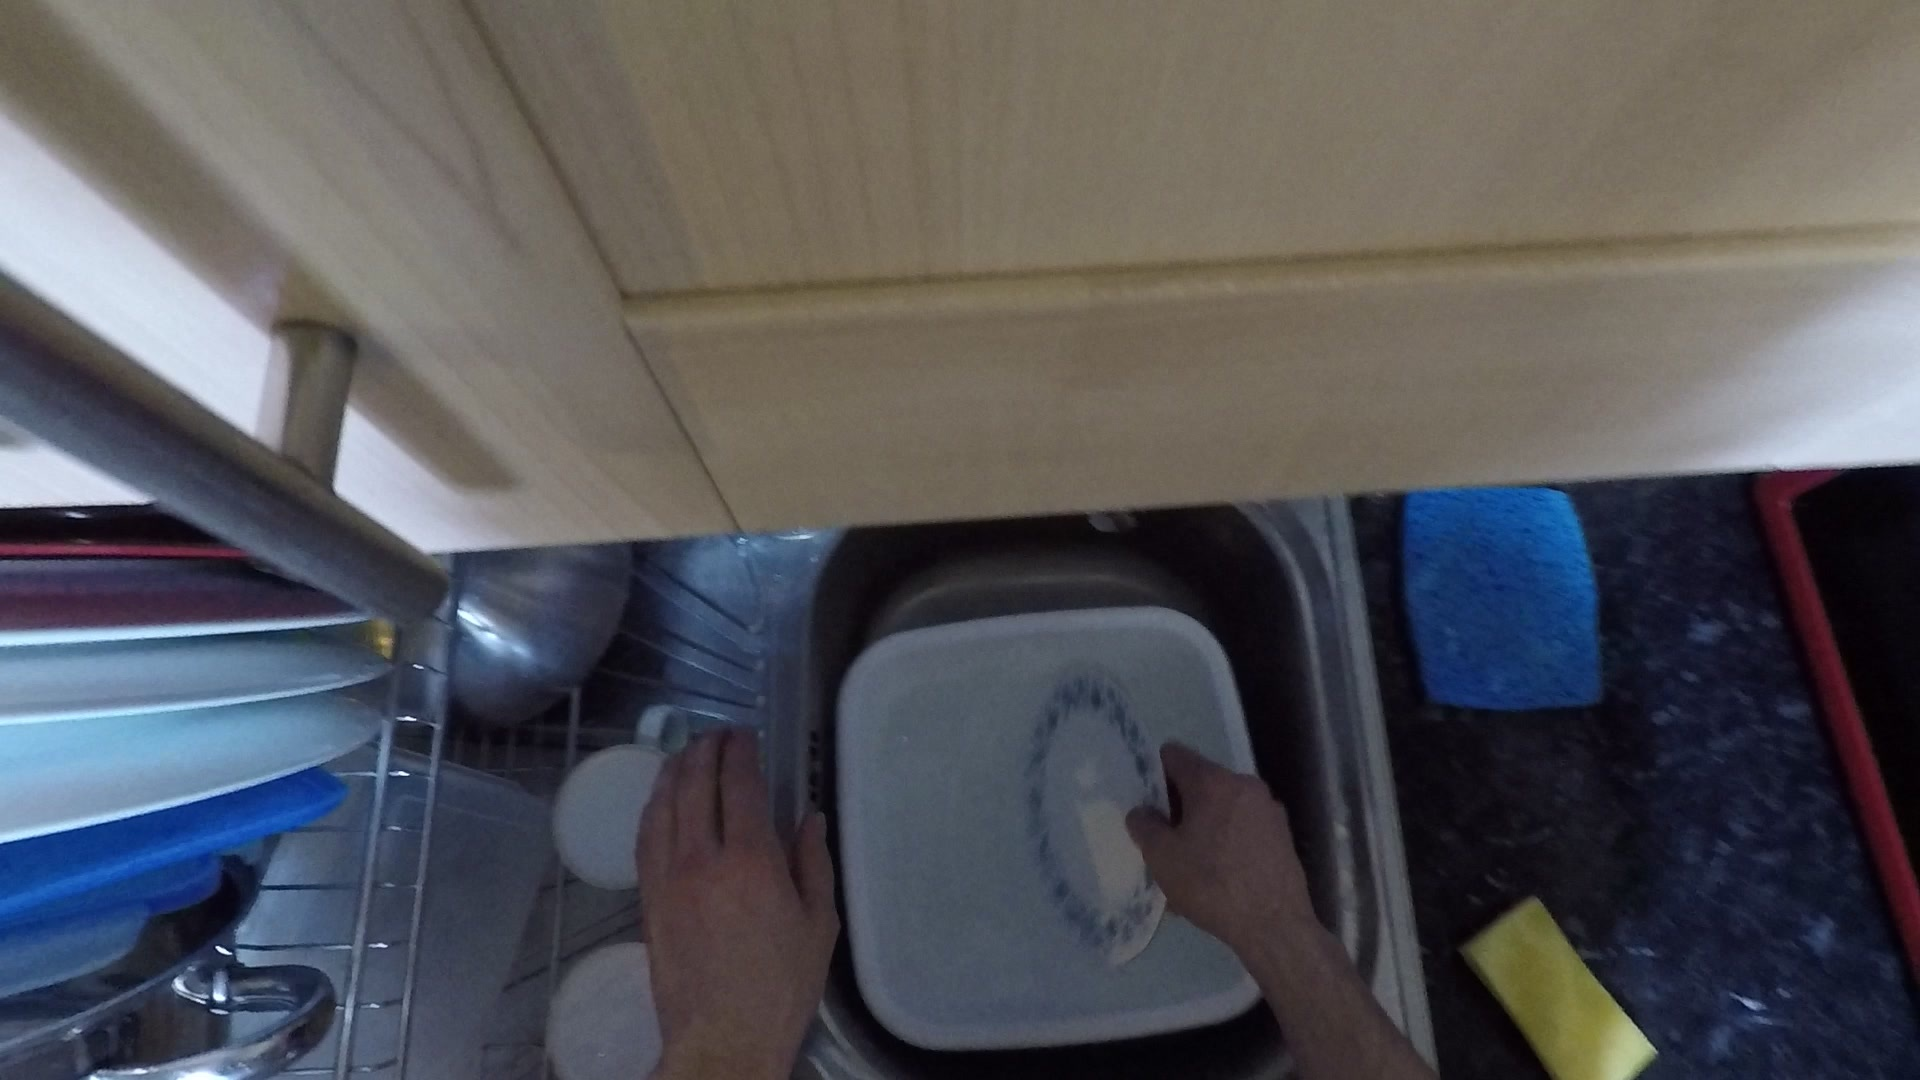

In [8]:
Image(filename=IMAGE)

In [6]:
# 读取bboxes信息

In [157]:
img = cv2.imread(IMAGE)
boxes = get_boxes(os.path.join(SAVE_PATH, IMAGE_NAME + '_unnorm.txt'))
boxes_info(boxes, CLS)


Normalised bounding box 0: hand
    conf    LT_x    LT_y    RB_x    RB_y
--------  ------  ------  ------  ------
0.823596    1119     741    1315     960

Normalised bounding box 1: hand
    conf    LT_x    LT_y    RB_x    RB_y
--------  ------  ------  ------  ------
0.746083     620     734     846    1034


## Traditional way: Position
仅通过手相对位置来判断。

In [143]:
def diff_hand(boxes):
    """Differentiate the predited bounding boxes into two labels. <left_hand>, <right_hand>
    Arguments:
        boxes: predicted bounding boxes, format: (ID, centre_x, centre_y, width, height)
    Return:
        diff_boxes: differentiated bounding boxes, format: (ID, centre_x, centre_y, width, height), where ID relates to new 'labels'.
    """
    # Differentiate simply by left-right position
    n_hands = len(boxes)

    if n_hands == 0:
        print("No hands detected.")
    elif n_hands == 2:
        c_x0 = (boxes[0][2] + boxes[0][4]) / 2  # center x0
        c_x1 = (boxes[1][2] + boxes[1][4]) / 2  # center x1
        boxes[0][0] = int(c_x0 > c_x1)
        boxes[1][0] = int(c_x0 < c_x1)
    else:
        pass
    return boxes

In [144]:
# 仅通过位置信息判断

In [155]:
boxes = diff_hand(boxes)
boxes_info(boxes, NEW_CLS)


Normalised bounding box 0: right_hand
    conf    LT_x    LT_y    RB_x    RB_y
--------  ------  ------  ------  ------
0.823596    1119     741    1315     960

Normalised bounding box 1: left_hand
    conf    LT_x    LT_y    RB_x    RB_y
--------  ------  ------  ------  ------
0.746083     620     734     846    1034


In [37]:
# 输出box信息和展示判断结果

In [148]:
def save_result(boxes, img, labels, save_path):
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(boxes))]
    # boxes = scale_coords(torch.Size([320, 512]), boxes, img.shape).round()
    for box in boxes:
        label = '%s %.2f' % (labels[box[0]], box[1])
        plot_one_box(box[2:], img, label=label, color=colors[box[0]])
    cv2.imwrite(save_path, img)

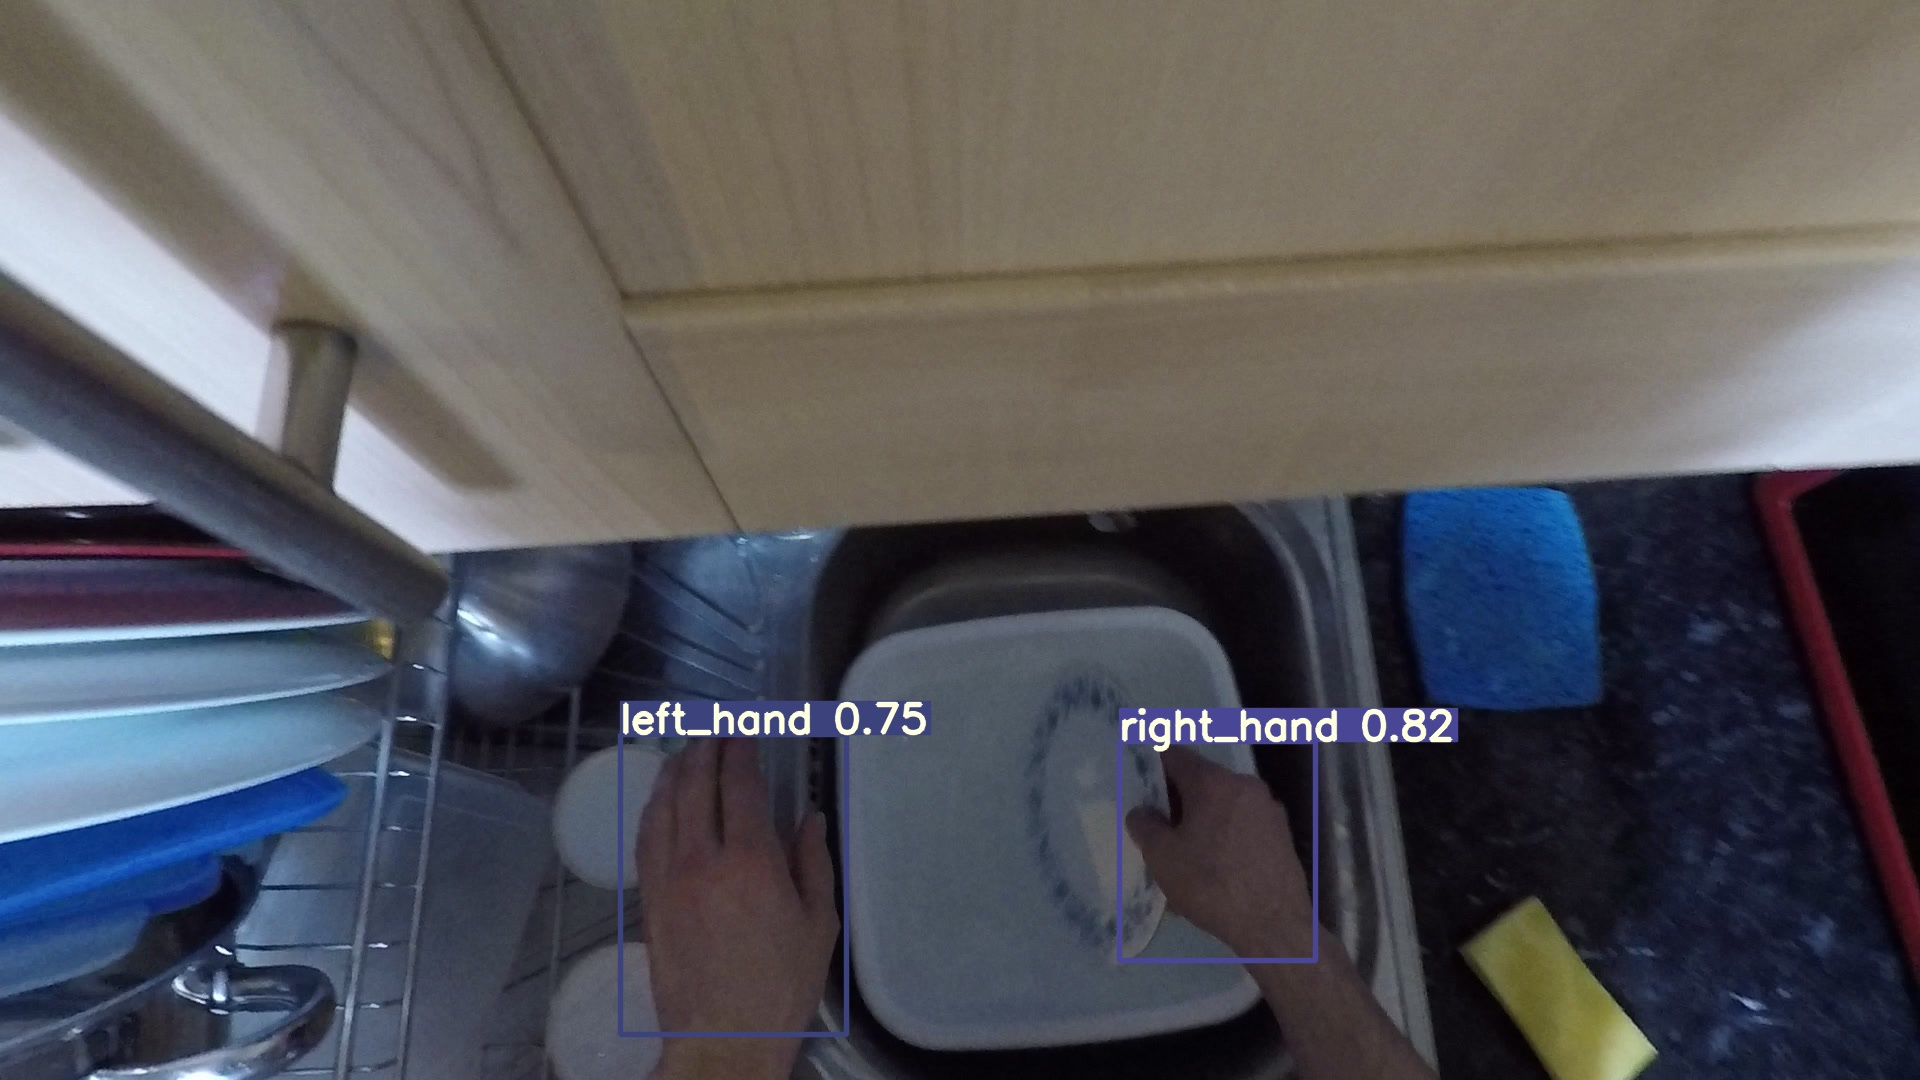

In [151]:
save_img_path = os.path.join(SAVE_PATH, 'diff.jpg')
save_result(boxes, img, NEW_CLS, save_img_path)
Image(filename=save_img_path)

In [59]:
# 保存类名

In [152]:
with open(os.path.join(SAVE_PATH, 'egohands.names'), 'w') as f:
    for n in NEW_CLS:
        f.write('{}\n'.format(n))

In [153]:
# 保存新的box文件
with open(os.path.join(SAVE_PATH, IMAGE_NAME + '_unnorm_diff.txt'), 'w') as f:
    for box in boxes:
        f.write(' '.join([str(i) for i in box]) + '\n')

## Position and orientation
通过位置和角度同时决定左右手。

初步采取下列步骤：
![](images/differentiate.png)

In [158]:
# 只有手标签的boxes
boxes

[[0, 0.823596, 1119.0, 741.0, 1315.0, 960.0],
 [0, 0.746083, 620.0, 734.0, 846.0, 1034.0]]

In [159]:
xyxy.shape

(2, 4)

### 预处理

In [160]:
# 图片格式从BGR变为RGB
img = cv2.imread(IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 获得list，包含所有裁片，类型为numpy array
crops = crop_bbox(img, boxes)

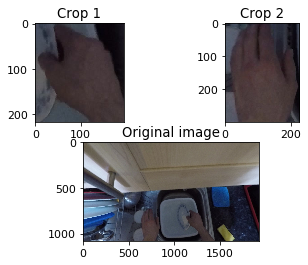

In [161]:
ax1 = plt.subplot(212)
ax1.imshow(img)
ax1.set_title('Original image')

ax2 = plt.subplot(221)
ax2.imshow(crops[0])
ax2.set_title('Crop 1')

ax3 = plt.subplot(222)
ax3.imshow(crops[1])
ax3.set_title('Crop 2')

plt.show()

In [162]:
# 对于单个裁片进行处理
crop = crops[0]
print('Before flattening: ', crop.shape)

Before flattening:(219, 196, 3)


In [163]:
# 去噪
crop_blur = cv2.blur(crop, (3, 3))  # 均值滤波
crop_blur = cv2.GaussianBlur(crop_blur, (3, 3), 0)  # 高斯滤波
crop_blur = cv2.medianBlur(crop_blur, 5)    # 中值滤波

In [164]:
# 提取手部
# 人的手部是颜色各异的，所以一般的采用颜色空间设定阈值的方法并不一定靠谱，如何不靠谱，之后要靠实验测试。这里先采用不用人为设定阈值的方法。

In [122]:
# 方法一：采用KMeans clustering获取手部
def kmeansMask(region, k=3):
    """KMeans Clustering on the region to get the hand.

    Reference: https://morioh.com/p/b6763f7527d5

    Returns:
        masked_region: 
        avg_color:
    """
    # 将3D的图片reshape为2D的array，即宽高二维上压平为一维
    pixel_values = region.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    # print('After flattening: ', pixel_values.shape)

    # 停止策略
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # kmeans clustering
    k = 3
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 坐标类型恢复
    centers = np.uint8(centers)

    segmented_region = centers[labels.flatten()]  # 配对对应label
    segmented_region = segmented_region.reshape(region.shape) # 恢复size
    # plt.imshow(segmented_region)
    # plt.show()

    # 找到最大的cluster，也就是出现次数最多的label
    most_label = np.bincount(labels.flatten()).argmax()
    # print('Most frequently: %s' % most_label)

    # 选择性显示/掩膜显示
    colors = [[random.randint(200, 255) for _ in range(3)] for _ in range(3)]

    masked_region = np.copy(region)
    masked_region = masked_region.reshape((-1, 3))
    mask = labels == most_label
    # masked_region[mask[:, 0], :] = colors[1]  # 最大的区域染色
    masked_region[~mask[:, 0], :] = [0, 0, 0] # 其余统一为黑色
    masked_region = masked_region.reshape(region.shape)
    # plt.imshow(masked_region)
    # plt.show()

    # 找到手的平均颜色（即cluster的平均颜色）
    most_mask = labels == most_label
    most_avg = np.mean(pixel_values[most_mask[:, 0], :], axis=0, dtype=np.int32)
    # color_demo = np.tile(most_avg, 10000).reshape((100, 100, 3))

    return masked_region, most_avg

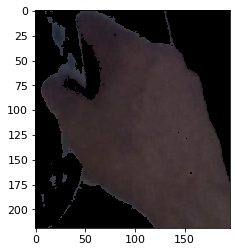

Average color:[60 48 51]


In [165]:
kmeans_masked_crop, most_avg = kmeansMask(crop, k=3)
plt.imshow(kmeans_masked_crop)
plt.show()
print("Average color: ", most_avg)

# 发现图片整体分为k个颜色了，虽然并不是一种颜色都在一块，但是可以观察到，手的区域比较大（因为bbox本来就是识别手）

# 一个问题是：k=3并不一定是一直有效，这个得取决于手的颜色是否均匀

In [166]:
# 方法二： YCrCb颜色空间Cr分量+OTSU法阈值分割算法
# References: https://blog.csdn.net/qq_41562704/article/details/88975569
def skinMask(region):
	YCrCb = cv2.cvtColor(region, cv2.COLOR_RGB2YCrCb) #转换至YCrCb空间
	(y,cr,cb) = cv2.split(YCrCb) #拆分出Y,Cr,Cb值
	cr1 = cv2.GaussianBlur(cr, (5,5), 0)
	_, skin = cv2.threshold(cr1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) #Ostu处理
	res = cv2.bitwise_and(region,region, mask = skin)
	return res

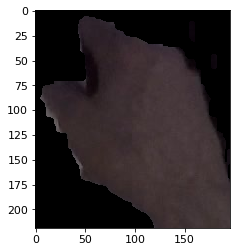

In [167]:
skin_masked_crop = skinMask(crop)
plt.imshow(skin_masked_crop)
plt.show()

In [168]:
# 可以看到第二种方法能够在肤色提取不受光照影响而且分割也比较干净
# 不管是哪种方法提取的手部，背景都不会很干净，进一步的预处理是对分割出来的手部做腐蚀和膨胀操作（开运算），把面积较小的区域减少甚至消除。

In [169]:
def openOperation(region, kernel_size=3):
    kernel = np.ones((kernel_size,kernel_size), np.uint8)   #设置卷积核
    erosion = cv2.erode(region, kernel)     #腐蚀操作
    dilation = cv2.dilate(erosion, kernel)  #膨胀操作
    return dilation

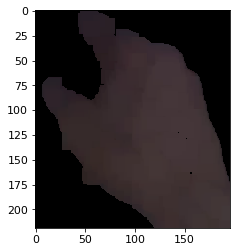

In [170]:
# 对KMeans聚类法提取的手部进行开运算
opened_kmeans_crop = openOperation(kmeans_masked_crop, kernel_size=13)
plt.imshow(opened_kmeans_crop)
plt.show()

In [171]:
most_avg

array([60, 48, 51])

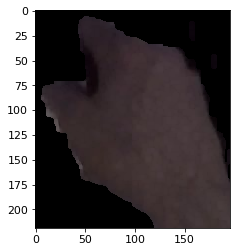

In [172]:
# 对颜色模型法提取的手部进行开运算
opened_skin_crop = openOperation(skin_masked_crop)
plt.imshow(opened_skin_crop)
plt.show()

In [173]:
extract_mask = opened_skin_crop != [0,0,0]
extract_region = opened_skin_crop[extract_mask[:, :, 0], :]
skin_avg = np.mean(extract_region, axis=0)

In [174]:
# 观察到两种方法经过开运算之后纯净了更多，虽然有锯齿，但是只有一整块区域了。

In [179]:
# 手部扩展：将手部扩展到能够包含手臂

In [180]:
# 对手部扩展框进行同样的预处理
exd_crops = extendRegion(img, boxes, 1)
exd_crop = exd_crops[0]

In [181]:
# 颜色限制
def colorMask(region, color, thres=50):
    flatten_region = (region - color).reshape((-1, 3))
    near_mask = np.linalg.norm(flatten_region, axis=1) < 50

    masked_region = np.copy(region)
    masked_region = masked_region.reshape((-1,3))
    masked_region[~near_mask, :] = [0,0,0]
    masked_region = masked_region.reshape(region.shape)

    return masked_region

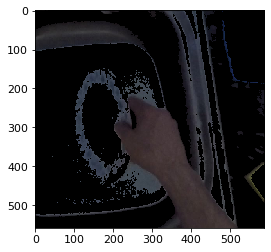

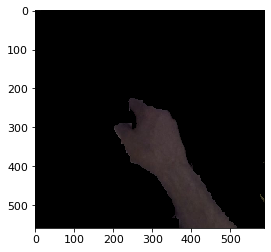

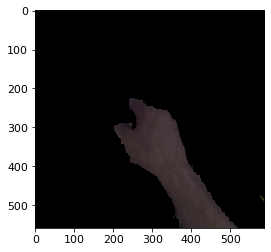

In [182]:
color_masked_crop = colorMask(exd_crop, skin_avg, 40)
plt.imshow(color_masked_crop)
plt.show()

# 颜色模型法
skin_masked_exd_crop = skinMask(color_masked_crop)
plt.imshow(skin_masked_exd_crop)
plt.show()

# 开运算
opened_skin_masked_exd_crop = openOperation(skin_masked_exd_crop)
plt.imshow(opened_skin_masked_exd_crop)
plt.show()

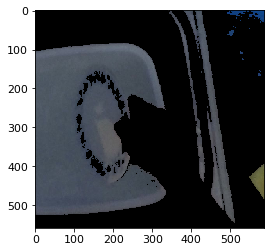

In [183]:
# KMeans聚类法：如果不做颜色限制容易识别到别的物体上，因为手不一定是最大区域，而且随着区域变大，KMeans的运算量会显著增大
kmeans_masked_exd_crop, _ = kmeansMask(exd_crop)
plt.imshow(kmeans_masked_exd_crop)
plt.show()

所以归结出以下判断：
针对提取**手以及周围区域内的手臂**问题：
- KMeans聚类方法来提取手部很依赖手在边界框中的占比，既然是通过找最大面积聚类作为手，那么如果存在手占比不大的情况（如手在相机视角是侧视的），就很容易提取错区域。
- KMeans聚类法在边界框区域较大的时候计算量很大，容易导致处理时间变长。
- 颜色模型法作为一种无差别而且计算量随着尺寸线性增长的方法，比较始于这个任务。

算法流程：

获取裁片 -> 去噪 -> 颜色模型阈值分割 -> 形态学开运算 -> 提取平均颜色 -> 扩展裁片 -> 颜色阈值筛 -> 颜色模型阈值分割 -> 形态学开运算

In [9]:
# 这样的分割方法有一点需要注意：如果两只手有重叠，那么分割可能分割成一个区域，所以最好将此种分割方法放在两边界框（两只手）没有交叉的情况下。

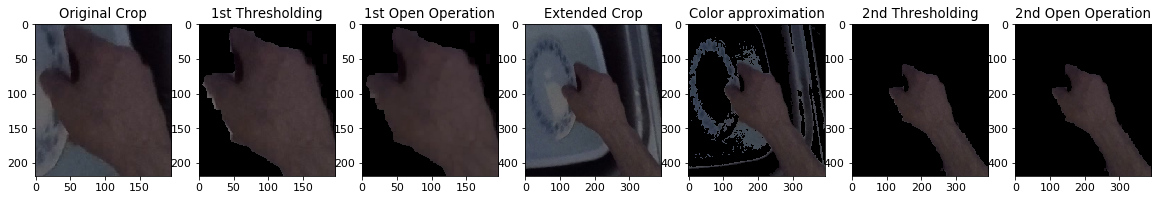

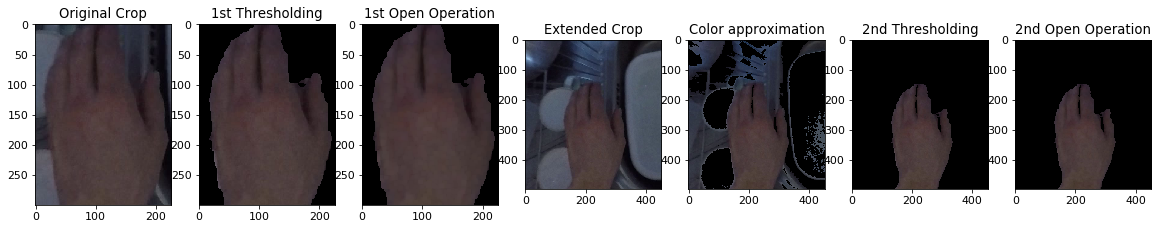

In [282]:
# 快速展示
img = cv2.imread(IMAGE)
boxes = get_boxes(os.path.join(SAVE_PATH, IMAGE_NAME + '_unnorm.txt'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
extracted, exd_boxes = extractHandArm(img, boxes, open_size=5, extend_scale=0.5,color_thres=20, view=True)

# Ellipse/Line/Rectangle fitting

注意cv2的函数输出的角度和直觉的角度是不一样的，需要手动加上转换过程：

![](images/rectify_angle.png)

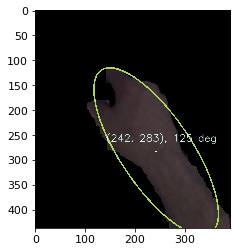

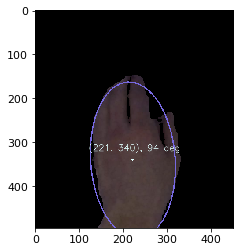

In [185]:
ellpse_info = ellipseFit(
    regions=extracted,
    bin_thres=10,
    view=True
)

## Hand identification

根据https://arxiv.org/abs/1607.06264提出的经验分布：

![](images/distribution.png)

观察到的规律是：对于手和手臂拟合椭圆的中心和角度来说，
- 当中心在左半平面，且角度为锐角时，大概率是左手；
- 当中心在左半平面，且角度为钝角时，大概率是右手；
- 当中心在右半平面，且角度为钝角时，大概率是右手；（角度和上图表示稍有不同）
- 当中心在右半平面，且角度为锐角时，大概率时左手。

这四条规律比较适合只存在**单个边界框**的情况。

发现情况总结就是：锐角左手，钝角右手，先这么做。如果不是一锐一钝这种情况，就左边左右边右。

**N.B.** 不考虑场景中出现第三只手，或者其他人的手。
如果存在镜像，为了避免产生bug，如有三只手，将采用分数比较保留识别手置信度较高的两个进行判断。

更简单的决策过程：统计数据集中心和角度数据，生成分布或者训练神经网络。

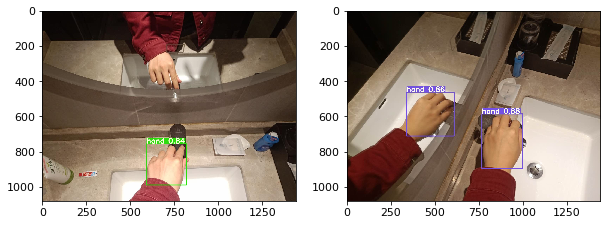

In [136]:
# 镜像情况
mirror1 = cv2.imread('output/mirror1/mirror1.jpg')
mirror2 = cv2.imread('output/mirror2/mirror2.jpg')
mirror1 = cv2.cvtColor(mirror1, cv2.COLOR_BGR2RGB)
mirror2 = cv2.cvtColor(mirror2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(mirror1)
plt.subplot(122)
plt.imshow(mirror2)
plt.show()

In [211]:
print(
    '\nboxes:' , boxes,
    '\nexd_boxes:', exd_boxes,
    '\nimage.shape:', img.shape
)


boxes:[[0, 0.823596, 1119.0, 741.0, 1315.0, 960.0], [0, 0.746083, 620.0, 734.0, 846.0, 1034.0]]
exd_boxes:[[          0      0.8236        1021         632        1413        1069]
 [          0     0.74608         507         584         959        1080]]
image.shape:(1080, 1920, 3)


In [283]:
boxes.append([0, 0.2, 350, 773, 500, 900])
boxes

[[0, 0.823596, 1119.0, 741.0, 1315.0, 960.0],
 [0, 0.746083, 620.0, 734.0, 846.0, 1034.0],
 [0, 0.2, 350, 773, 500, 900]]

In [284]:
boxes = diff_hands(img, boxes)

In [285]:
boxes

array([[          1,      0.8236,        1119,         741,        1315,         960],
       [          0,     0.74608,         620,         734,         846,        1034]])

In [286]:
boxes_info(boxes, NEW_CLS)


Normalised bounding box 0: right_hand
    conf    LT_x    LT_y    RB_x    RB_y
--------  ------  ------  ------  ------
0.823596    1119     741    1315     960

Normalised bounding box 1: left_hand
    conf    LT_x    LT_y    RB_x    RB_y
--------  ------  ------  ------  ------
0.746083     620     734     846    1034


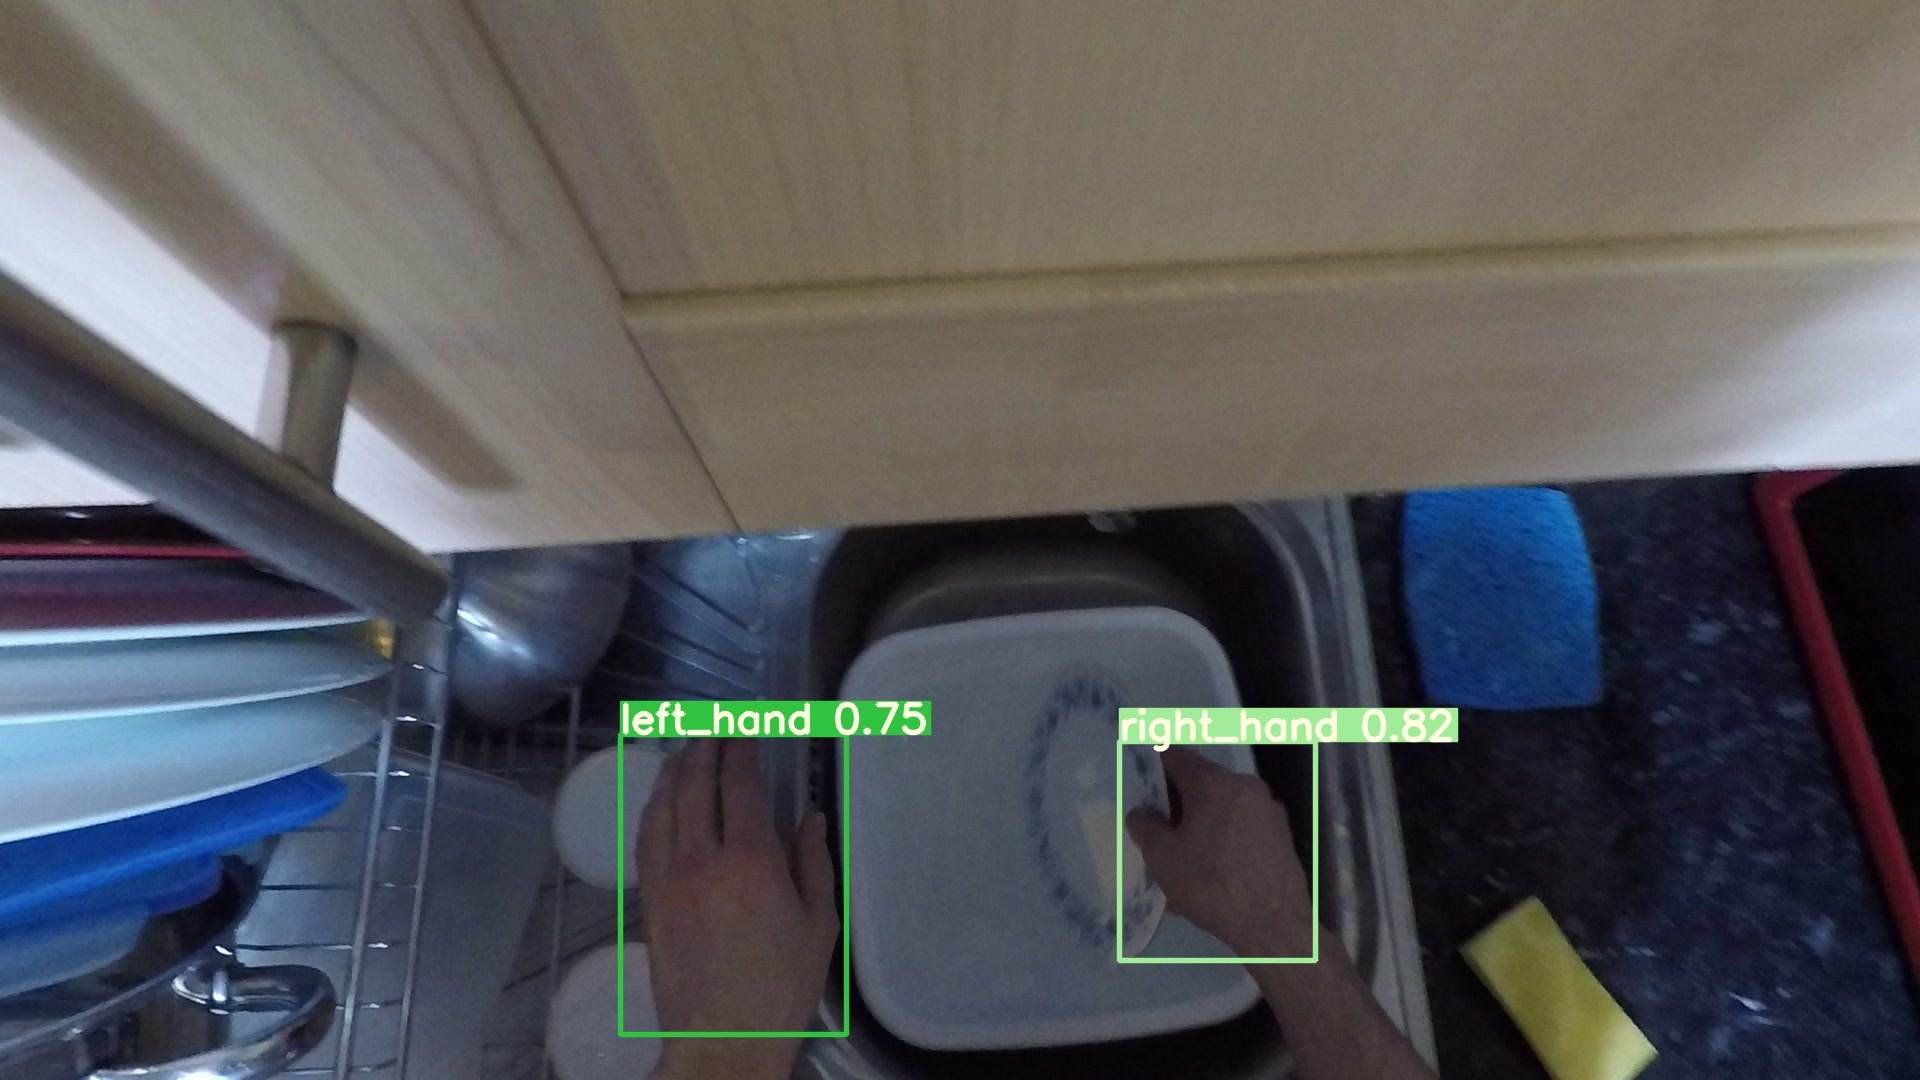

In [287]:
save_img_path = os.path.join(SAVE_PATH, 'diff_full.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
save_result(boxes, img, NEW_CLS, save_img_path)
Image(filename=save_img_path)

In [291]:
boxes

array([[          1,      0.8236,        1119,         741,        1315,         960],
       [          0,     0.74608,         620,         734,         846,        1034]])

In [303]:
# 保存类名
# 保存新的box文件
with open(os.path.join(SAVE_PATH, IMAGE_NAME + '_unnorm_diff_full.txt'), 'w') as f:
    for box in boxes:
        box = box.tolist()
        f.write(('%g ' * 6 + '\n') % (*box, ))